# Event-based composites

Identifying some interesting events or features (such as heat waves, the tropopause, the ice edge, etc.) in meteorological data is a common task in climate science.

Manually looping over the data to find the events, and then looping over the data to create composites tends to be very slow in python.

For this purpose I wrote a tiny package to facilitate event-based composites based on xarra data, called [xevent](https://github.com/jonas-spaeth/xevent).

See an example here to compute heat wave composites based on air temperature.

In [1]:
!python --version

Python 3.12.9


In [2]:
import xarray as xr
import numpy as np
import ultraplot as uplt
import xevent

for pkg in [uplt, xr, np]:
    print(f"{pkg.__name__}: {pkg.__version__}")

ultraplot: 1.57.2
xarray: 2025.7.1
numpy: 2.3.1


In [3]:
ds = xr.tutorial.open_dataset("air_temperature").compute()
ds

<xarray.Dataset> Size: 31MB
Dimensions:  (time: 2920, lat: 25, lon: 53)
Coordinates:
  * lat      (lat) float32 100B 75.0 72.5 70.0 67.5 65.0 ... 22.5 20.0 17.5 15.0
  * lon      (lon) float32 212B 200.0 202.5 205.0 207.5 ... 325.0 327.5 330.0
  * time     (time) datetime64[ns] 23kB 2013-01-01 ... 2014-12-31T18:00:00
Data variables:
    air      (time, lat, lon) float64 31MB 241.2 242.5 243.5 ... 296.2 295.7
Attributes:
    Conventions:  COARDS
    title:        4x daily NMC reanalysis (1948)
    description:  Data is from NMC initialized reanalysis\n(4x/day).  These a...
    platform:     Model
    references:   http://www.esrl.noaa.gov/psd/data/gridded/data.ncep.reanaly...

In [4]:
# heat waves: maximum temperature anomalies during extended summer above 90th percentile

EXT_SUMMER_MONTHS = [5, 6, 7, 8, 9]  # May to September
ds_extended_summer = ds.sel(time=ds.time.dt.month.isin(EXT_SUMMER_MONTHS))
ds_extended_summer = ds_extended_summer.resample(time="1D").mean(
    "time"
)  # Resample to daily means
anom = ds_extended_summer.groupby("time.month") - ds_extended_summer.groupby(
    "time.month"
).mean("time")


def get_list_of_heatwaves(data, quantile_threshold):
    hot_days = data > data.quantile(quantile_threshold, dim="time")
    diff = hot_days.astype("int").diff("time")

    dims_for_events = ["time", "lat", "lon"]
    diff_stacked = diff.stack(datapoint=dims_for_events)
    diff_stacked = diff_stacked.where(diff_stacked > 0, drop=True)

    event_df = diff_stacked.datapoint.to_dataframe()
    event_list = event_df.drop(
        columns=[c for c in event_df.columns if c not in dims_for_events]
    ).to_dict("records")
    return event_list


QUANTILE_THRESHOLD = 0.95
event_list = get_list_of_heatwaves(anom, QUANTILE_THRESHOLD)
event_list[:5]

[{'time': Timestamp('2013-05-02 00:00:00'), 'lat': 65.0, 'lon': 305.0},
 {'time': Timestamp('2013-05-02 00:00:00'), 'lat': 65.0, 'lon': 322.5},
 {'time': Timestamp('2013-05-02 00:00:00'), 'lat': 62.5, 'lon': 305.0},
 {'time': Timestamp('2013-05-02 00:00:00'), 'lat': 60.0, 'lon': 300.0},
 {'time': Timestamp('2013-05-02 00:00:00'), 'lat': 60.0, 'lon': 302.5}]

In [5]:
xevent.composite?

Signature:
xevent.composite(
    data: xarray.core.dataarray.DataArray | xarray.core.dataset.Dataset,
    events: list[dict],
    relative_coords: dict,
    interpolate: bool = False,
) -> xarray.core.dataarray.DataArray | xarray.core.dataset.Dataset
Docstring:
Create a composite of events from a dataset or dataarray.add()

Parameters
----------
data : xr.DataArray  |  xr.Dataset
    Input data.
events : list[dict]
    List of events, each event is a dictionary with keys that correspond to the dimensions of the data.
relative_coords : dict
    For each coordinate that should center around the event, provide a list of relative coordinates,
    e.g. given a dimension "x" with values ``[0, 1, 2, 3, 4, 5]``,
    relative_coords = ``dict(x=[-1, 0, 1])`` would result in a composite with values at ``[-1, 0, 1]`` relative to the event
interpolate : bool, optional
    If False, use xarray's .sel() method to select datapoints. If True, use xarray's .interp() method to interpolate. Defaults to Fa

In [6]:
%%time

# decide on relative coordinates for the composite
relative_coords = dict(
    time=np.arange(-6, 7, 2, dtype="timedelta64[D]"),
    lat=np.arange(-20, 21, 2.5),
    lon=np.arange(-20, 21, 2.5),
)

# create the composite using xevent
composite = xevent.composite(
    data=anom, events=event_list, relative_coords=relative_coords
)
composite

CPU times: user 162 ms, sys: 37.7 ms, total: 199 ms
Wall time: 200 ms


<xarray.Dataset> Size: 194MB
Dimensions:   (event: 11676, rel_lat: 17, rel_lon: 17, rel_time: 7)
Coordinates:
    lat       (event, rel_lat) float64 2MB 45.0 47.5 50.0 ... 32.5 35.0 37.5
    lon       (event, rel_lon) float64 2MB 285.0 287.5 290.0 ... 222.5 225.0
    time      (event, rel_time) datetime64[ns] 654kB 2013-04-26 ... 2014-10-06
    month     (event, rel_time) float64 654kB nan nan nan 5.0 ... nan nan nan
  * event     (event) int64 93kB 0 1 2 3 4 5 ... 11671 11672 11673 11674 11675
  * rel_time  (rel_time) timedelta64[s] 56B -6 days -4 days ... 4 days 6 days
  * rel_lat   (rel_lat) float64 136B -20.0 -17.5 -15.0 -12.5 ... 15.0 17.5 20.0
  * rel_lon   (rel_lon) float64 136B -20.0 -17.5 -15.0 -12.5 ... 15.0 17.5 20.0
Data variables:
    air       (event, rel_time, rel_lat, rel_lon) float64 189MB nan nan ... nan

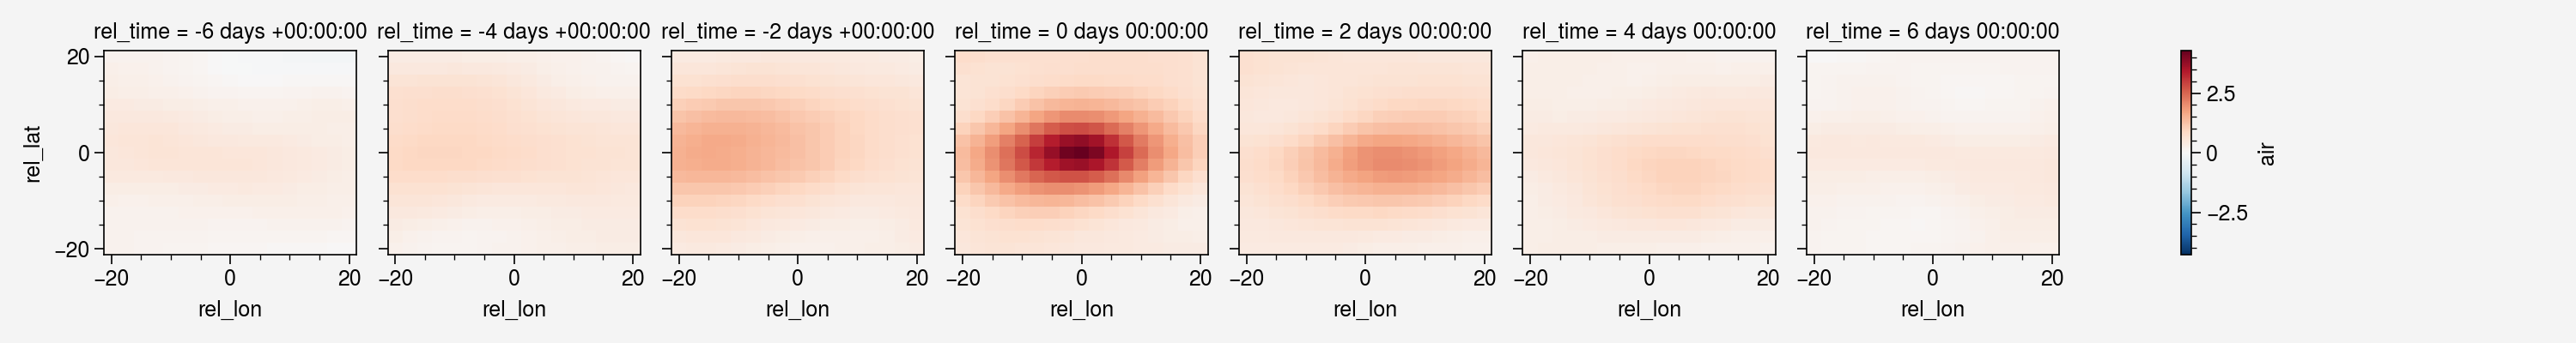

In [7]:
composite.air.mean(dim="event").plot(col="rel_time", size=2)